# Excercise 3

## Load the data

In [1]:
def load_data(pickle_file):
    import pickle

    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

## Plot the images

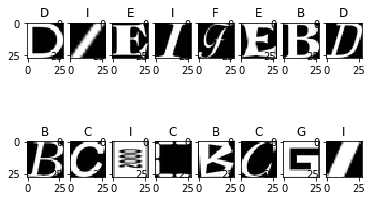

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def label_to_char(one_hot):
    return "ABCDEFGHIJ"[one_hot]

n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))
    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(label_to_char(train_labels[image_to_show]))


## Helper Functions

In [3]:
image_size = 28
num_labels = 10

# Convert 2 to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  labels = to_one_hot(labels)
  return dataset, labels

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))

## Simple classification pipeline

In [4]:
import numpy as np

def accuracy(predictions, labels):
    return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))
  



## Hands-On: Our first Neural Network

Now it's time to create your first Neural Network. 

**Hints**:

You can use the following functions:

    tf.matmul
    tf.nn.softmax
    tf.nn.softmax_cross_entropy_with_logits


In [5]:
import tensorflow as tf

class TensorNeuralNetwork:
    def __init__(self):
        self.num_steps = 5001
        self.batch_size = 128
        self.num_relu = 1024
        self.image_size = 28
    
    def fit(self, train_data, train_labels):
        graph = tf.Graph()
        with graph.as_default():
          tf_train_dataset = tf.placeholder(tf.float32,
                                            shape=(self.batch_size, self.image_size * self.image_size))
          tf_train_labels = tf.placeholder(tf.float32, shape=(self.batch_size, num_labels))

          # Variables.
          weights_1 = tf.Variable(tf.truncated_normal([self.image_size * self.image_size, self.num_relu]))
          biases_1 = tf.Variable(tf.zeros([self.num_relu]))

          hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
          hidden_output = tf.nn.relu(hidden_input)

          weights_2 = tf.Variable(tf.truncated_normal([self.num_relu, num_labels]))
          biases_2 = tf.Variable(tf.zeros([num_labels]))

          # Training computation.
          logits = tf.matmul(hidden_output, weights_2) + biases_2

          # Loss to optimize
          loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

          # Optimizer.
          optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

          # Predictions for the training, validation, and test data.
          train_prediction = tf.nn.softmax(logits)
        
        dataset, labels = reformat(train_dataset, train_labels)

        with tf.Session(graph=graph) as session:
          tf.global_variables_initializer().run()
          print_row(['Step', 'Loss', 'Acc-Train'])
          for step in range(self.num_steps):
            offset = (step * self.batch_size) % (labels.shape[0] - self.batch_size)
            batch_data = dataset[offset:(offset + self.batch_size), :]
            batch_labels = labels[offset:(offset + self.batch_size), :]

            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}

            _, l, predictions, w1, b1, w2, b2 = session.run(
                [
                    optimizer, loss, train_prediction, 
                    weights_1, biases_1, weights_2, biases_2
                ], 
                feed_dict=feed_dict
            )

            if (step % 500 == 0):
              test_acc = accuracy(from_one_hot(predictions), from_one_hot(batch_labels))

              print_row([step, l, test_acc])
        
        self.weights_1 = w1
        self.biases_1 = b1
        self.weights_2 = w2
        self.biases_2 = b2
        
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        graph = tf.Graph()
        with graph.as_default():
            weights_1 = tf.constant(self.weights_1)
            biases_1 = tf.constant(self.biases_1)
            weights_2 = tf.constant(self.weights_2)
            biases_2 = tf.constant(self.biases_2)
            tfdata = tf.constant(data)
            
            hidden_input = tf.matmul(tfdata, weights_1) + biases_1
            hidden_output = tf.nn.relu(hidden_input)
            
            logits = tf.matmul(hidden_output, weights_2) + biases_2
            
            prediction = tf.nn.softmax(logits)
            
        with tf.Session(graph=graph) as session:
            tf.global_variables_initializer().run()
            predictions, _ = session.run([prediction, logits])
            return from_one_hot(predictions)


In [6]:
evaluate_classifier(TensorNeuralNetwork())

Step                Loss                Acc-Train           
0                   347.788             0.1171875           
500                 0.207412            0.984375            
1000                0.00906892          0.9921875           
1500                0.0103709           0.9921875           
2000                5.99748e-06         1.0                 
2500                1.07101e-07         1.0                 
3000                1.76951e-08         1.0                 
3500                0.0                 1.0                 
4000                8.46606e-05         1.0                 
4500                9.8625e-07          1.0                 
5000                3.97769e-06         1.0                 
Test accuracy: 0.874
